# MSc Artificial Intelligence Dissertation

## Unsupervised multimodal machine translation using visual signals as rewards for reinforcement learning


#### By Gargeya Sharma (220278025)(ec22146@qmul.ac.uk)


Experimental Setup with Finalized settings

In [1]:
%load_ext autoreload
%autoreload 2

### Requirements Installation (Only for the First run)

!pip3 install wandb==0.15.7
!pip3 install datasets==2.14.1
!pip3 install transformers==4.31.0
!pip3 install trl==0.4.7
!pip3 install sentencepiece==0.1.99
!pip3 install portalocker>=2.0.0
!pip3 install sacremoses==0.0.53
!pip3 install sacrebleu==2.3.1
!pip3 install torch==2.0.1
!pip install tqdm==4.65.0
!pip install matplotlib

### Import dependencies

In [2]:
import random
import torch
import wandb
import time
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from random import choices
import matplotlib.pyplot as plt
tqdm.pandas()
from PIL import Image
import evaluate
import nltk
nltk.download("wordnet")

from datasets import load_dataset
from functools import partial

from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, pipeline, ViltProcessor, ViltForImageAndTextRetrieval, AutoModelForSeq2SeqLM

from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead, create_reference_model, AutoModelForSeq2SeqLMWithValueHead

[nltk_data] Downloading package wordnet to /home/ec22146/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import os

# Set the CUDA_VISIBLE_DEVICES environment variable to the desired GPU ID

os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Replace 1 with the GPU ID you want to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Running on device: {device}")

Running on device: cuda


### Configuration

In [4]:

config = PPOConfig(
    model_name="Helsinki-NLP/opus-mt-de-en",
    steps=50, # 29000/8 (size of the dataset/ batch size)
    batch_size=580,
    learning_rate=1.41e-9, # changed from 1.41e-5
    remove_unused_columns=False,
    log_with="wandb"
)

seed = 42

fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [5]:
np.random.seed(seed)

### Load data and models

#### Load pre-trained Opus (German to English) language model

We load the opus-mt-de-en model with a value head and the tokenizer. We load the model twice; the first model is optimized while the second model serves as a reference to calculate the KL-divergence from the starting point. This serves as an additional reward signal in the PPO training to make sure the optimized model does not deviate too much from the original language model.

In [6]:
opus_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(config.model_name)

opus_model_ref = create_reference_model(opus_model)

opus_tokenizer = AutoTokenizer.from_pretrained(config.model_name)

opus_tokenizer.pad_token = opus_tokenizer.eos_token

#### Load Multi30K dataset
The Multi30k dataset is a collection of 30,000 images and corresponding textual descriptions in English, German, Czech and French. It's a widely-used dataset for multilingual image description and machine translation tasks. In this research, The textual part of the dataset was utilized for training the opus model, whereas the image part was utilized by the multimodel ViLT model to provide rewards, focusing on the unsupervised German-to-English translation.

! git clone https://github.com/multi30k/dataset.git

In [7]:
## Zipped Images corresponding to the textual dataset
data_path = "./flickr30k-images"

def get_multi30k(from_lang:str="de", to_lang:str="en", split:str="train"):
  ## Testing file has a different name hence this condition
  if split != "test":
    with open(f"./dataset/data/task1/tok/{split}.lc.norm.tok.{from_lang}") as from_file, open(f"./dataset/data/task1/tok/{split}.lc.norm.tok.{to_lang}") as to_file, open(f"./dataset/data/task1/image_splits/{split}.txt", 'r') as img_split:
      image_split = img_split.read()
      image_split = image_split.split("\n")
      dataset = list(zip(image_split, from_file.readlines(), to_file.readlines()))
      print("size of the dataset: ",len(dataset))
  else:
    ## Train and val file names have similar structure
    with open(f"./dataset/data/task1/tok/{split}.lc.norm.tok.{from_lang}") as from_file, open(f"./dataset/data/task1/tok/{split}.lc.norm.tok.{to_lang}") as to_file, open(f"./dataset/data/task1/image_splits/{split}.txt", 'r') as img_split:
      image_split = img_split.read()
      image_split = image_split.split("\n")
      dataset = list(zip(image_split, from_file.readlines(), to_file.readlines()))
      print("size of the dataset: ",len(dataset))

  dataset = list(map(lambda x: {"image":x[0],"from":x[1][:-1],"to":x[2][:-1]}, dataset))  ## Removing '\n' from the end of each sentence
  return dataset

train_dataset = get_multi30k()
valid_dataset = get_multi30k(split='val')
test_2016_flickr = get_multi30k(split='test_2016_flickr')
test_2017_flickr = get_multi30k(split='test_2017_flickr')
test_2018_flickr = get_multi30k(split='test_2018_flickr')
test_2017_mscoco = get_multi30k(split='test_2017_mscoco')
train_dataset[0]

size of the dataset:  29000
size of the dataset:  1014
size of the dataset:  1000
size of the dataset:  1000
size of the dataset:  1071
size of the dataset:  461


{'image': '1000092795.jpg',
 'from': 'zwei junge weiße männer sind im freien in der nähe vieler büsche .',
 'to': 'two young , white males are outside near many bushes .'}

*After uploading the dataset.zip, this was used to unzip the dataset*:\
!tar -xf ./flickr30k-images.tar.gz

two young , white males are outside near many bushes .


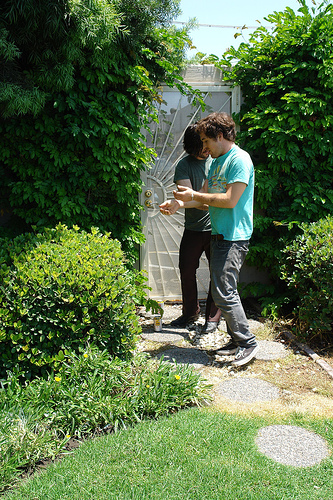

In [8]:
print(train_dataset[0]["to"])
Image.open(f'{data_path}/{train_dataset[0]["image"]}')

#### Tokenize input description and then detokenize them

We tokenize all the German data in advance to avoid tokenizing twice. In the first step, I encode the German language with max-length of encoding to 25, truncation = True while experimenting with both padding = "max-length" and False. In a second step, we decode these tokens back to the text for later display while also replacing any different symbol between the words with new space.

In [1]:
def up_dataset(line):
  """Data prepartion"""
  line["input_ids"] = torch.tensor(opus_tokenizer.encode(line['from'], max_length=25, truncation=True, add_special_tokens=False),dtype=torch.int)
  line["query"] = opus_tokenizer.decode(line["input_ids"]) ## 'query' should be same as 'from', this will be the input to the model
  temp = line['query'].split('▁')
  line['query'] = " ".join(temp)
  return line

In [16]:
# Apply the function defined above on both training and validation dataset
train_dataset = tuple(map(up_dataset, train_dataset)) 
valid_dataset = tuple(map(up_dataset, valid_dataset))

print(train_dataset[0])

{'image': '1000092795.jpg', 'from': 'zwei junge weiße männer sind im freien in der nähe vieler büsche .', 'to': 'two young , white males are outside near many bushes .', 'input_ids': tensor([  338,  5338, 17270,    17, 28237,    70,    49,  6017,     5,     9,
           17, 21108, 10949,    17, 10585,  3351,    17,     3],
       dtype=torch.int32), 'query': ' zwei junge weiße männer sind im freien in der nähe vieler büsche.'}


In [17]:
## For PPOTrainer, we need to dataset prepared in torch.utils.data.Dataset

class Multi30KDataset(Dataset):
  def __init__(self, dataset):
    super()
    self.image_path = dataset["image"]
    self.from_lang = dataset["from"]
    self.to_lang = dataset["to"]
    self.input_ids = dataset["input_ids"]
    self.query = dataset["query"]

  def __len__(self):
    return len(self.query)

  def __getitem__(self, idx):
    from_lang = self.from_lang[idx]
    to_lang = self.to_lang[idx]
    input_ids = self.input_ids[idx]
    query = self.query[idx]
    image_path = self.image_path[idx]
    sample = {"image": image_path, "from":from_lang, "to": to_lang,"input_ids":input_ids, "query":query}
    return sample

In [18]:
# Preprocessing both training and validation dataset in the required data type.

df = pd.DataFrame(train_dataset)
train_dataset = Multi30KDataset(df)

valid_dataset = pd.DataFrame(valid_dataset)
valid_dataset = Multi30KDataset(valid_dataset)


In [19]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

To run your own model, you need your W&B access key.

In [16]:
ppo_trainer = PPOTrainer(config, opus_model, opus_model_ref, opus_tokenizer, train_dataset, data_collator=collator)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: grey8magic (gargeya). Use `wandb login --relogin` to force relogin


In [17]:
if ppo_trainer.accelerator.num_processes == 1:
    device = 1 if torch.cuda.is_available() else "cpu" # to avoid a `pipeline` bug
else:
    device = ppo_trainer.accelerator.device

In [18]:
device

1

### Reward Functions

#### Unsupervised Reward using ViLT Transformer
We load the ViLT model's Visual Reasoning setting to attain a score between the relevance of the image and the text to work as the run-time reward during the training.

In [20]:
## Reward Function using Visual BERT for Visual Reasoning score to pass for the model training

def load_vilt():
  processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-coco", device=device)
  vilt_model = ViltForImageAndTextRetrieval.from_pretrained("dandelin/vilt-b32-finetuned-coco")
  return processor, vilt_model

vilt_processor, vilt_model = load_vilt()
def get_rewards_from_vilt(image_path, target_desc, processor=vilt_processor, vilt_model = vilt_model):
  image_path = f"./flickr30k-images/{image_path}"
  image = Image.open(image_path)
  text = target_desc

  # forward pass
  encoding = processor(image, text, return_tensors="pt", truncation=True, max_length=40)
  outputs = vilt_model(**encoding)
  score = outputs.logits[0, :].item()
  
  return torch.tensor(round(score, 2)) #score

def get_rewards(image_batch, target_batch):
  rewards = []
  for image_path, target_desc in zip(image_batch, target_batch):
    rewards.append(get_rewards_from_vilt(image_path, target_desc))
  rewards = np.array(rewards)
  temp = np.clip(rewards, -8, 8)
  temp = (temp +8)/16
  temp = temp*100
  rewards = np.round(temp, 2) + 1e-6 ## Avoiding the reward to reach value:'0'
  rewards = list(map(lambda x: torch.tensor(x), rewards))
  return rewards


get_rewards(["10002456.jpg"], ["several men in hard hats are operating a giant pulley system."])

[tensor(80.9400)]

#### Examples to check scores given by ViLT
(3 unique cases)

Reward:  tensor(4.9500)


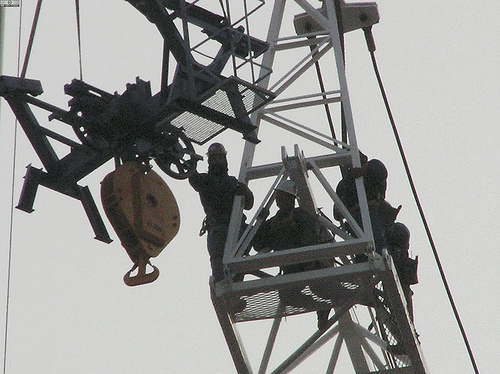

In [19]:
sample_path = "10002456.jpg"
sample_desc = "several men in hard hats are operating a giant pulley system ."

reward = get_rewards_from_vilt(image_path=sample_path, target_desc=sample_desc)
print("Reward: ",reward)
sample_path = f"./flickr30k-images/{sample_path}"
Image.open(sample_path)

Reward:  tensor(-11.1400)


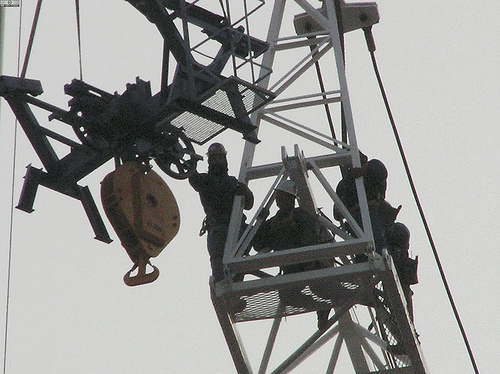

In [20]:
# False Negative Example

sample_path = "10002456.jpg"
sample_desc = "A camel is drinking water in a dessert"

reward = get_rewards_from_vilt(image_path=sample_path, target_desc=sample_desc)
print("Reward: ",reward)
sample_path = f"./flickr30k-images/{sample_path}"
Image.open(sample_path)

Reward:  tensor(5.4300)


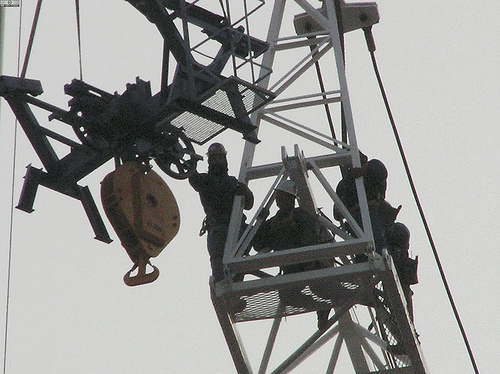

In [21]:
# Hilarious Example I came across while showing a negative reward! Hahahah!!!!

## The reward is higher than that of the original prompt.

sample_path = "10002456.jpg"
sample_desc = "A turbine working in the sea with few penguins around it."

reward = get_rewards_from_vilt(image_path=sample_path, target_desc=sample_desc)
print("Reward: ",reward)
sample_path = f"./flickr30k-images/{sample_path}"
Image.open(sample_path)

#### Supervised Cumulative **Bleu** score
For supervised learning, we are using the consecutive cumulative **bleu** score between the prediction text and the target text to work as the reward during the training.

In [1]:
from sacrebleu import corpus_bleu
def bleu_score(li_abs_hyp, li_abs_ref):
    """
    Computes the BLEU score
    :param li_abs_hyp: list of hypothesis abstracts (token strings)
    :param li_abs_ref: list of reference abstracts (token strings)
    """
    bleu = corpus_bleu(li_abs_hyp, [li_abs_ref])

    return bleu.score

In [20]:
## Trying with another reward function

def cummulative_bleu(target_desc, label_desc):
    rewards = 0
    cummulative_words = []
    for word in target_desc.split(" "):
        cummulative_words.append(word)
        words = " ".join(cummulative_words)
        rewards += torch.tensor(bleu_score([words], [label_desc]))
    return rewards

def get_rewards_bleu(target_batch, label_batch):
    '''Getting rewards on batches of data'''
    rewards = []
    for target_desc, label_desc in zip(target_batch, label_batch):
        rewards.append(cummulative_bleu(target_desc, label_desc))
    return rewards

In [21]:
cummulative_bleu("a group of men invites cotton on a truck", "a group of men are loading cotton onto a truck")

tensor(165.6264)

### Generation settings

In [25]:
generation_kwargs = {
    "min_length":2,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": opus_tokenizer.eos_token_id,
    "max_new_tokens": 13,
    "eos_token_id": opus_tokenizer.eos_token_id
}


## Optimize model

**Steps** 

The training loop consists of the following steps:
1. Get a batch of tokenized inputs as query tensors to pass to the Opus model 
2. Get the query responses as response tokens from the policy
3. Cleanly detokenize the response tokens in the target language
4. Pass the batch of strings generated in step 3 with corresponding images to the reward function
6. Take the rewards obtained from step 4 and Optimize the policy with PPO using the (query, response, reward) triplet
7. Log all the training statistics to weights and biases

**Training time**

This step takes **~5h** on a RTX 6000 GPU with the above specified settings.

In [26]:
print(device)

1


## Unsupervised using the visual signals

In [ ]:
for epoch in range(1):
    for batch in tqdm(ppo_trainer.dataloader):
        logs, game_data,  = dict(), dict()

        game_data['query'] = batch["query"]
        query_tensors = batch["input_ids"]  
        #### get response from Opus
        response_tensors = []
        for query in query_tensors:
            response = ppo_trainer.generate(query, **generation_kwargs)
            response_tensors.append(response.squeeze())
#         print(len(response_tensors), len(response_tensors[0]))
        game_data['response'] = list(map(lambda x: opus_tokenizer.decode(x[1:], skip_special_tokens=True, clean_up_tokenization_space=True), response_tensors))
        
        rewards = get_rewards(image_batch=batch["image"], target_batch=game_data['response'])
        
        stats = ppo_trainer.step(query_tensors, response_tensors, rewards)

        #for cs in ctrl_str:
        key = 'env/reward'
        stats[key] = np.mean([r.cpu().numpy() for r in rewards])
        ppo_trainer.log_stats(stats, game_data, rewards)

## Supervised training using the bleu score as the rewards

In [ ]:
for epoch in range(1):
    for batch in tqdm(ppo_trainer.dataloader):
        logs, game_data,  = dict(), dict()

        game_data['query'] = batch["query"]
        game_data["labels"] = batch["to"]
        query_tensors = batch["input_ids"]  
        #### get response from Opus
        response_tensors = []
        for query in query_tensors:
            response = ppo_trainer.generate(query, **generation_kwargs)
            response_tensors.append(response.squeeze())
#         print(len(response_tensors), len(response_tensors[0]))
        game_data['response'] = list(map(lambda x: opus_tokenizer.decode(x[1:], skip_special_tokens=True, clean_up_tokenization_space=True), response_tensors))
        print(game_data['response'])
        print(game_data['labels'])
        rewards = get_rewards_bleu(target_batch=game_data['response'], label_batch = game_data['labels'])
        
        stats = ppo_trainer.step(query_tensors, response_tensors, rewards)

        #for cs in ctrl_str:
        key = 'env/reward'
        stats[key] = np.mean([r.cpu().numpy() for r in rewards])
        ppo_trainer.log_stats(stats, game_data, rewards)

## Save model
Finally, we save the model to disk for later usage.

In [25]:
completed_models = {"first": {"model":"opus-model", "tok":"opus_tokenizer"},
                   "second":{"model":"grey-opus", "tok":"grey-opus-tok"},
                   "third":{"model":"opus-model", "tok":"opus_tokenizer"},
                    "fourth":{"model": "grey-opus2-lower-lr-linear-loss", "tok":"grey-opus-tok2-lower-lr-linear-loss"},
                   "fifth":{"model": "grey-opus3-1.41e-9-lr-bs-580-linear-loss-0-100", "tok":"grey-opus-tok3-1.41e-9-lr-bs-580-linear-loss-0-100"},
                   "sixth":{"model":"supervised-bleu", "tok":"supervised-bleu-tok"}}

In [26]:
latest_model = list(completed_models.values())[-1]["model"]
latest_tok = list(completed_models.values())[-1]["tok"]
print(latest_model, latest_tok)

supervised-bleu supervised-bleu-tok


In [27]:
opus_model.eval()
opus_model.save_pretrained(latest_model)
opus_tokenizer.save_pretrained(latest_tok)

('supervised-bleu-tok/tokenizer_config.json',
 'supervised-bleu-tok/special_tokens_map.json',
 'supervised-bleu-tok/vocab.json',
 'supervised-bleu-tok/source.spm',
 'supervised-bleu-tok/target.spm',
 'supervised-bleu-tok/added_tokens.json')

# Model Inspection

## Bleu Score

In [1]:
from sacrebleu import corpus_bleu
def bleu_score(li_abs_hyp, li_abs_ref):
    """
    Computes the BLEU score
    :param li_abs_hyp: list of hypothesis abstracts (token strings)
    :param li_abs_ref: list of reference abstracts (token strings)
    """
    bleu = corpus_bleu(li_abs_hyp, [li_abs_ref])

    return bleu.score

In [2]:
#valid_dataset.from_lang.tolist() # Just checking the validation inputs

### Validation Data

In [ ]:
# device = "cpu"

In [67]:
## Inference on the pretrianed model

from transformers import MarianMTModel, MarianTokenizer

src_text = valid_dataset.from_lang.tolist()

model_name="Helsinki-NLP/opus-mt-de-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name).to(device)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True).to(device), pad_token_id = tokenizer.eos_token_id)

pretrained_predictions = []
for t in translated:
    pretrained_predictions.append(tokenizer.decode(t, skip_special_tokens=True))

In [ ]:
pretrained_predictions

In [38]:
## Inference on the supervised model

from transformers import MarianMTModel, MarianTokenizer

src_text = valid_dataset.from_lang.tolist()

model_name = "./supervised-bleu"
tokenizer = MarianTokenizer.from_pretrained("./supervised-bleu-tok")
model = MarianMTModel.from_pretrained(model_name).to(device)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True).to(device), pad_token_id = tokenizer.eos_token_id)

supervised_predictions = []
for t in translated:
    supervised_predictions.append(tokenizer.decode(t[1:], skip_special_tokens=True))

Some weights of the model checkpoint at ./supervised-bleu were not used when initializing MarianMTModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing MarianMTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MarianMTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [45]:
supervised_predictions # = list(map(lambda x: x.split("<pad> ")[1], predictions))

In [58]:
## Inference on the unsupervised model

from transformers import MarianMTModel, MarianTokenizer

src_text = valid_dataset.from_lang.tolist()

model_name = "./grey-opus3-1.41e-9-lr-bs-580-linear-loss-0-100"
tokenizer = MarianTokenizer.from_pretrained("./grey-opus-tok3-1.41e-9-lr-bs-580-linear-loss-0-100")
model = MarianMTModel.from_pretrained(model_name).to(device)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True).to(device), pad_token_id = tokenizer.eos_token_id)

unsupervised_predictions = []
for t in translated:
    unsupervised_predictions.append(tokenizer.decode(t[1:], skip_special_tokens=True))

Some weights of the model checkpoint at ./grey-opus3-1.41e-9-lr-bs-580-linear-loss-0-100 were not used when initializing MarianMTModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing MarianMTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MarianMTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/ec22146/grey/greyenv/lib64/python3.9/site-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
 

In [ ]:
unsupervised_predictions

In [69]:
validation_results = pd.DataFrame({
    "query": src_text, #valid_dataset.from_lang.tolist()
    "target": valid_dataset.to_lang.tolist(),
    "pretrained": pretrained_predictions,
    "supervised": supervised_predictions,
    "unsupervised":unsupervised_predictions
})

In [73]:
validation_results#.to_csv("Validation_inference.csv", index=False)

,query,target,pretrained,supervised,unsupervised
0,eine gruppe von männern lädt baumwolle auf ein...,a group of men are loading cotton onto a truck,a group of men loads cotton on a truck,a group of men invites cotton to a truck,a group of men invites cotton on a truck
1,ein mann schläft in einem grünen raum auf eine...,a man sleeping in a green room on a couch .,a man sleeps in a green room on a sofa.,a man sleeps in a green room on a sofa.,a man sleeps in a green room on a sofa.
2,ein junge mit kopfhörern sitzt auf den schulte...,a boy wearing headphones sits on a woman &apos...,a boy with headphones sitting on the shoulders...,a boy with headphones sitting on the shoulders...,a boy with headphones sitting on the shoulders...
3,zwei männer bauen eine blaue eisfischerhütte a...,two men setting up a blue ice fishing hut on a...,two men build a blue ice fishing hut on a froz...,two men build a blue ice fishing hut on a froz...,two men build a blue ice fishing hut on a froz...
4,"ein mann mit beginnender glatze , der eine rot...",a balding man wearing a red life jacket is sit...,"a man with beginning glitter, who wears a red ...","a man with beginning glatze, who wears a red l...","a man with beginning glatze, who wears a red r..."
...,...,...,...,...,...
1009,bei einer art jahrmarkt stellt ein mann zucker...,"at some sort of carnival , a man is making cot...",at a kind of fair manufactures a man sugar cot...,at a kind of fair manufactures a man sugar cot...,at a kind of annual market produces a man suga...
1010,eine gruppe von polizisten steht vor einem bus .,a bunch of police officers are standing outsid...,a group of police officers stands in front of ...,a group of police officers standing in front o...,a group of police officers stands in front of ...
1011,eine ältere weißhaarige frau sieht in ihre kas...,a elderly white-haired woman is looking inside...,an older white-haired woman looks into her box...,an older white-haired woman looks into her che...,an older white-haired woman looks into her box...
1012,zwei männer stehen an telefonzellen im freien .,two men are standing at telephone booths outsi...,two men stand on cell phones in the open.,two men stand on cell phones in the open.,two men stand on cell phones in the open.


In [109]:
bleu_on_val = pd.DataFrame({
    "model":["pretrained", "supervised","unsupervised"],
    "Bleu score":[bleu_score(validation_results["target"].tolist(), validation_results["pretrained"].tolist()),
    bleu_score(validation_results["target"].tolist(), validation_results["supervised"].tolist()),
    bleu_score(validation_results["target"].tolist(), validation_results["unsupervised"].tolist())]
})

bleu_on_val

,model,Bleu score
0,pretrained,35.390839
1,supervised,35.401004
2,unsupervised,34.810459


### Test Set

In [3]:
# device="cpu"

In [14]:
test_2016_flickr = pd.DataFrame(test_2016_flickr)
test_2017_flickr = pd.DataFrame(test_2017_flickr)
test_2018_flickr = pd.DataFrame(test_2018_flickr)
test_2017_mscoco = pd.DataFrame(test_2017_mscoco)

#### On test_2016_flickr

In [19]:
## Inference on the pretrianed model

from transformers import MarianMTModel, MarianTokenizer

src_text = test_2016_flickr["from"].tolist()

model_name="Helsinki-NLP/opus-mt-de-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name).to(device)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True).to(device), pad_token_id = tokenizer.eos_token_id)

pretrained_predictions = []
for t in translated:
    pretrained_predictions.append(tokenizer.decode(t, skip_special_tokens=True))


## Inference on the supervised model

model_name = "./supervised-bleu"
tokenizer = MarianTokenizer.from_pretrained("./supervised-bleu-tok")
model = MarianMTModel.from_pretrained(model_name).to(device)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True).to(device), pad_token_id = tokenizer.eos_token_id)

supervised_predictions = []
for t in translated:
    supervised_predictions.append(tokenizer.decode(t[1:], skip_special_tokens=True))


## Inference on the unsupervised model

model_name = "./grey-opus3-1.41e-9-lr-bs-580-linear-loss-0-100"
tokenizer = MarianTokenizer.from_pretrained("./grey-opus-tok3-1.41e-9-lr-bs-580-linear-loss-0-100")
model = MarianMTModel.from_pretrained(model_name).to(device)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True).to(device), pad_token_id = tokenizer.eos_token_id)

unsupervised_predictions = []
for t in translated:
    unsupervised_predictions.append(tokenizer.decode(t[1:], skip_special_tokens=True))



test_2016_flickr_results = pd.DataFrame({
    "query": src_text,
    "target": test_2016_flickr["to"].tolist(),
    "pretrained": pretrained_predictions,
    "supervised": supervised_predictions,
    "unsupervised":unsupervised_predictions
})

test_2016_flickr_results.to_csv("test_2016_flickr_inference.csv", index=False)
test_2016_flickr_results.head()

Some weights of the model checkpoint at ./supervised-bleu were not used when initializing MarianMTModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing MarianMTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MarianMTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at ./grey-opus3-1.41e-9-lr-bs-580-linear-loss-0-100 were not used when initializing MarianMTModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing MarianMTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model fr

,query,target,pretrained,supervised,unsupervised
0,"ein mann mit einem orangefarbenen hut , der et...",a man in an orange hat starring at something .,a man with an orange hat staring at something.,a man with an orange hat staring at something.,a man with an orange hat that stares at someth...
1,ein boston terrier läuft über saftig-grünes gr...,a boston terrier is running on lush green gras...,a boston terrier runs over juicy green grass i...,a boston terrier runs over juicy green grass i...,a boston terrier runs over juicy-green grass i...
2,ein mädchen in einem karateanzug bricht ein br...,a girl in karate uniform breaking a stick with...,a girl in a karate suit breaks a board with a ...,a girl in a karate suit breaks a board with a ...,a girl in a karate suit breaks a board with a ...
3,fünf leute in winterjacken und mit helmen steh...,five people wearing winter jackets and helmets...,five people in winter jackets and with helmets...,five people in winter jackets and with helmets...,five people in winter jackets and with helmets...
4,leute reparieren das dach eines hauses .,people are fixing the roof of a house .,People repair the roof of a house.,People repair the roof of a house.,People repair the roof of a house.


#### On test_2017_flickr

In [ ]:
## Inference on the pretrianed model

from transformers import MarianMTModel, MarianTokenizer

src_text = test_2017_flickr["from"].tolist()

model_name="Helsinki-NLP/opus-mt-de-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name).to(device)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True).to(device), pad_token_id = tokenizer.eos_token_id)

pretrained_predictions = []
for t in translated:
    pretrained_predictions.append(tokenizer.decode(t, skip_special_tokens=True))


## Inference on the supervised model

model_name = "./supervised-bleu"
tokenizer = MarianTokenizer.from_pretrained("./supervised-bleu-tok")
model = MarianMTModel.from_pretrained(model_name).to(device)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True).to(device), pad_token_id = tokenizer.eos_token_id)

supervised_predictions = []
for t in translated:
    supervised_predictions.append(tokenizer.decode(t[1:], skip_special_tokens=True))


## Inference on the unsupervised model

model_name = "./grey-opus3-1.41e-9-lr-bs-580-linear-loss-0-100"
tokenizer = MarianTokenizer.from_pretrained("./grey-opus-tok3-1.41e-9-lr-bs-580-linear-loss-0-100")
model = MarianMTModel.from_pretrained(model_name).to(device)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True).to(device), pad_token_id = tokenizer.eos_token_id)

unsupervised_predictions = []
for t in translated:
    unsupervised_predictions.append(tokenizer.decode(t[1:], skip_special_tokens=True))



test_2017_flickr_results = pd.DataFrame({
    "query": src_text,
    "target": test_2017_flickr["to"].tolist(),
    "pretrained": pretrained_predictions,
    "supervised": supervised_predictions,
    "unsupervised":unsupervised_predictions
})

test_2017_flickr_results.to_csv("test_2017_flickr_inference.csv", index=False)
test_2017_flickr_results.head()

#### On test_2018_flickr

In [23]:
## Inference on the pretrianed model

from transformers import MarianMTModel, MarianTokenizer

src_text = test_2018_flickr["from"].tolist()

model_name="Helsinki-NLP/opus-mt-de-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name).to(device)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True).to(device), pad_token_id = tokenizer.eos_token_id)

pretrained_predictions = []
for t in translated:
    pretrained_predictions.append(tokenizer.decode(t, skip_special_tokens=True))


## Inference on the supervised model

model_name = "./supervised-bleu"
tokenizer = MarianTokenizer.from_pretrained("./supervised-bleu-tok")
model = MarianMTModel.from_pretrained(model_name).to(device)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True).to(device), pad_token_id = tokenizer.eos_token_id)

supervised_predictions = []
for t in translated:
    supervised_predictions.append(tokenizer.decode(t[1:], skip_special_tokens=True))


## Inference on the unsupervised model

model_name = "./grey-opus3-1.41e-9-lr-bs-580-linear-loss-0-100"
tokenizer = MarianTokenizer.from_pretrained("./grey-opus-tok3-1.41e-9-lr-bs-580-linear-loss-0-100")
model = MarianMTModel.from_pretrained(model_name).to(device)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True).to(device), pad_token_id = tokenizer.eos_token_id)

unsupervised_predictions = []
for t in translated:
    unsupervised_predictions.append(tokenizer.decode(t[1:], skip_special_tokens=True))



test_2018_flickr_results = pd.DataFrame({
    "query": src_text,
    "target": test_2018_flickr["to"].tolist(),
    "pretrained": pretrained_predictions,
    "supervised": supervised_predictions,
    "unsupervised":unsupervised_predictions
})

test_2018_flickr_results.to_csv("test_2018_flickr_inference.csv", index=False)
test_2018_flickr_results.head()

/home/ec22146/grey/greyenv/lib64/python3.9/site-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Some weights of the model checkpoint at ./supervised-bleu were not used when initializing MarianMTModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing MarianMTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MarianMTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of

,query,target,pretrained,supervised,unsupervised
0,ein junger mann nimmt an einem lauf teil und d...,a young man participates in a career while the...,a young man participates in a run and the one ...,a young man participates in a run and the one ...,a young man participates in a run and the one ...
1,der mann sucht in einer buchhandlung nach eine...,the man is scratching the back of his neck whi...,the man is looking for a book in a bookstore a...,the man is looking for a book in a bookstore a...,the man is looking for a book in a bookstore a...
2,eine person mit schutzbrille und mütze fährt s...,a person wearing goggles and a hat is sled rid...,a person with goggles and chute rides sledges.,a person with goggles and chute rides sledge.,a person with goggles and chute rides sledges.
3,ein mädchen in pinkfarbener jacke und geblümte...,a girl in a pink coat and flowered goloshes sl...,a girl in pink jacket and flowered rubber boot...,a girl in pink jacket and flowered rubber boot...,a girl in pink jacket and flowered rubber boot...
4,drei mädchen stehen vor dem fenster eines gebä...,three girls are standing in front of a window ...,three girls standing in front of the window of...,three girls standing in front of the window of...,three girls stand in front of the window of a ...


#### On test_2017_mscoco

In [24]:
## Inference on the pretrianed model

from transformers import MarianMTModel, MarianTokenizer

src_text = test_2017_mscoco["from"].tolist()

model_name="Helsinki-NLP/opus-mt-de-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name).to(device)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True).to(device), pad_token_id = tokenizer.eos_token_id)

pretrained_predictions = []
for t in translated:
    pretrained_predictions.append(tokenizer.decode(t, skip_special_tokens=True))


## Inference on the supervised model

model_name = "./supervised-bleu"
tokenizer = MarianTokenizer.from_pretrained("./supervised-bleu-tok")
model = MarianMTModel.from_pretrained(model_name).to(device)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True).to(device), pad_token_id = tokenizer.eos_token_id)

supervised_predictions = []
for t in translated:
    supervised_predictions.append(tokenizer.decode(t[1:], skip_special_tokens=True))


## Inference on the unsupervised model

model_name = "./grey-opus3-1.41e-9-lr-bs-580-linear-loss-0-100"
tokenizer = MarianTokenizer.from_pretrained("./grey-opus-tok3-1.41e-9-lr-bs-580-linear-loss-0-100")
model = MarianMTModel.from_pretrained(model_name).to(device)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True).to(device), pad_token_id = tokenizer.eos_token_id)

unsupervised_predictions = []
for t in translated:
    unsupervised_predictions.append(tokenizer.decode(t[1:], skip_special_tokens=True))



test_2017_mscoco_results = pd.DataFrame({
    "query": src_text,
    "target": test_2017_mscoco["to"].tolist(),
    "pretrained": pretrained_predictions,
    "supervised": supervised_predictions,
    "unsupervised":unsupervised_predictions
})

test_2017_mscoco_results.to_csv("test_2017_mscoco_inference.csv", index=False)
test_2017_mscoco_results.head()

/home/ec22146/grey/greyenv/lib64/python3.9/site-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Some weights of the model checkpoint at ./supervised-bleu were not used when initializing MarianMTModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing MarianMTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MarianMTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of

,query,target,pretrained,supervised,unsupervised
0,"ich kann nicht sehen , wohin der grüne pfeil z...",i cannot see where the green arrow is pointing .,I can't see where the green arrow points.,I can't see where the green arrow points.,I can't see where the green arrow points.
1,eine liegende frau zeigt auf die kamera,a woman is pointing at the camera while lying ...,a lying woman pointing at the camera,a lying woman pointing at the camera,a lying woman points to the camera
2,"ein finger zeigt auf einen hotdog mit käse , s...","a finger pointing at a hotdog with cheese , sa...","a finger points to a hot dog with cheese, sour...","a finger points to a hot dog with cheese, sour...","a finger points to a hot dog with cheese, sour..."
3,"ein straßenschild mit vielen schildern , die z...",a very crowded street sign pointing to attract...,a street sign with many signs showing sights i...,a street sign with many signs showing sights i...,a road sign with many signs that show sights i...
4,mehrere menschen am strand mit surfbrettern un...,several people are on a beach with surf boards...,several people on the beach with surfboards an...,several people on the beach with surfboards an...,several people on the beach with surfboards an...


### Aggregating the Bleu scores in a Table

In [27]:
bleu_on_test = pd.DataFrame({
    "Models":["pretrained", "supervised","unsupervised"],
    "Test 2016 Flickr":[bleu_score(test_2016_flickr_results["target"].tolist(), test_2016_flickr_results["pretrained"].tolist()),
    bleu_score(test_2016_flickr_results["target"].tolist(), test_2016_flickr_results["supervised"].tolist()),
    bleu_score(test_2016_flickr_results["target"].tolist(), test_2016_flickr_results["unsupervised"].tolist())],

    "Test 2017 Flickr":[bleu_score(test_2017_flickr_results["target"].tolist(), test_2017_flickr_results["pretrained"].tolist()),
    bleu_score(test_2017_flickr_results["target"].tolist(), test_2017_flickr_results["supervised"].tolist()),
    bleu_score(test_2017_flickr_results["target"].tolist(), test_2017_flickr_results["unsupervised"].tolist())],

    "Test 2018 Flickr":[bleu_score(test_2018_flickr_results["target"].tolist(), test_2018_flickr_results["pretrained"].tolist()),
    bleu_score(test_2018_flickr_results["target"].tolist(), test_2018_flickr_results["supervised"].tolist()),
    bleu_score(test_2018_flickr_results["target"].tolist(), test_2018_flickr_results["unsupervised"].tolist())],

    "Test 2017 mscoco":[bleu_score(test_2017_mscoco_results["target"].tolist(), test_2017_mscoco_results["pretrained"].tolist()),
    bleu_score(test_2017_mscoco_results["target"].tolist(), test_2017_mscoco_results["supervised"].tolist()),
    bleu_score(test_2017_mscoco_results["target"].tolist(), test_2017_mscoco_results["unsupervised"].tolist())]
})

bleu_on_test

,Models,Test 2016 Flickr,Test 2017 Flickr,Test 2018 Flickr,Test 2017 mscoco
0,pretrained,34.984940,35.866271,33.097817,28.259535
1,supervised,35.410617,35.837973,33.050846,28.375846
2,unsupervised,34.836377,35.170239,32.322181,27.890286


## Meteor Score

In [28]:
def each_meteor_score(predictions, target):
    return round(nltk.translate.meteor_score.single_meteor_score(target, predictions),4)

In [29]:
def meteor_score(data, model):
    scores = []
    for target, predictions in zip(data[model].tolist(),data["target"].tolist()):
        scores.append(each_meteor_score(target.split(" "), predictions.split(" ")))
    return round(np.mean(scores),4)

#### On Validation dataset

In [9]:
meteor_on_val = pd.DataFrame({
    "model":["pretrained", "supervised","unsupervised"],
    "METEOR score":[meteor_score(vr, "pretrained"),
                   meteor_score(vr, "supervised"),
                   meteor_score(vr, "unsupervised")]
})

meteor_on_val

,model,METEOR score
0,pretrained,0.5847
1,supervised,0.5838
2,unsupervised,0.5805


In [32]:
meteor_on_test = pd.DataFrame({
    "Models":["pretrained", "supervised","unsupervised"],
    
    "Test 2016 Flickr":[meteor_score(test_2016_flickr_results, "pretrained"),
                   meteor_score(test_2016_flickr_results, "supervised"),
                   meteor_score(test_2016_flickr_results, "unsupervised")],

    "Test 2017 Flickr":[meteor_score(test_2017_flickr_results, "pretrained"),
                   meteor_score(test_2017_flickr_results, "supervised"),
                   meteor_score(test_2017_flickr_results, "unsupervised")],

    "Test 2018 Flickr":[meteor_score(test_2018_flickr_results, "pretrained"),
                   meteor_score(test_2018_flickr_results, "supervised"),
                   meteor_score(test_2018_flickr_results, "unsupervised")],

    "Test 2017 mscoco":[meteor_score(test_2017_mscoco_results, "pretrained"),
                   meteor_score(test_2017_mscoco_results, "supervised"),
                   meteor_score(test_2017_mscoco_results, "unsupervised")]
})

meteor_on_test

,Models,Test 2016 Flickr,Test 2017 Flickr,Test 2018 Flickr,Test 2017 mscoco
0,pretrained,0.5671,0.5823,0.5578,0.5326
1,supervised,0.5680,0.5811,0.5593,0.5336
2,unsupervised,0.5672,0.5778,0.5545,0.5317


---

#### Preparation for Significance Testing

In [3]:
import pandas as pd
test = pd.read_csv("test_2016_flickr_inference.csv")

with open("test2016-unsupervised.txt", 'w+') as file:
    file.write("\n".join(test.unsupervised.to_list()))


In [4]:
with open("base-pre.txt", "w+") as file:
    for hyp, ref in zip(test.pretrained.tolist(), test.target.tolist()):
        file.write(str(round(bleu_score([hyp], [ref]), 4))+"\n")
        

In [ ]:
with open("base-unsup.txt", "w+") as file:
    for hyp, ref in zip(test.unsupervised.tolist(), test.target.tolist()):
        file.write(str(round(bleu_score([hyp], [ref]), 4))+"\n")

In [4]:
with open("base-sup.txt", "w+") as file:
    for hyp, ref in zip(test.supervised.tolist(), test.target.tolist()):
        file.write(str(round(bleu_score([hyp], [ref]), 4))+"\n")

313385842.jpg


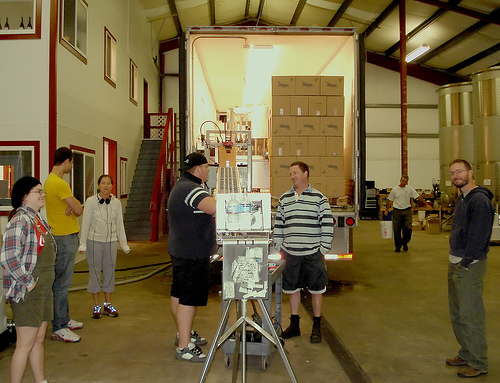

In [33]:
image1 = test_2016_flickr[test_2016_flickr["to"] == "two males seem to be conversing while standing in front of a truck &apos;s back , and behind a metal item , while four people stand around them ."]["image"].item()
print(image1)
Image.open(f"./flickr30k-images/{image1}")

3052436578.jpg


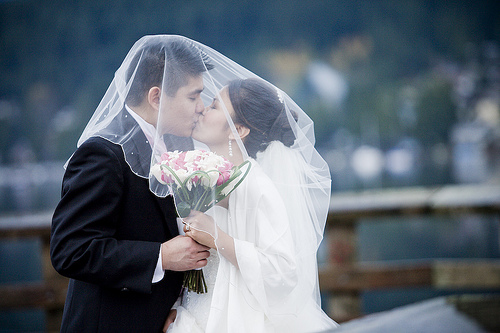

In [34]:
image2 = test_2016_flickr[test_2016_flickr["to"] == "a bride and groom kiss under the bride &apos;s veil ."]["image"].item()
print(image2)
Image.open(f"./flickr30k-images/{image2}")

In [37]:
test_2016_flickr[test_2016_flickr["to"] == "a bride and groom kiss under the bride &apos;s veil ."]["from"].item()

'eine braut und bräutigam küssen sich unter dem brautschleier .'